In [265]:
# import required libraries
import numpy as np 
import cv2 
from matplotlib import pyplot as plt 
import time

#### Create a function to display image

In [266]:
from matplotlib import pyplot as plt
def imshow(img, figsize=(6, 6)):
    fig, ax = plt.subplots(1, 1, figsize=(figsize))
    ax.axis('off')
    ax.imshow(img)

In [267]:
def cylindricalWarp(img, K):
    h, w = img.shape[:2]
    y, x = np.indices((h, w))
    y = y - h/2
    x = x - w/2
    f = K[0, 0]
    theta = np.arctan2(x, f)
    h_new = h
    w_new = w
    y_new = f * np.tan(y / f)
    x_new = f * theta
    y_new = y_new + h_new/2
    x_new = x_new + w_new/2
    x_new = x_new.astype(np.float32)
    y_new = y_new.astype(np.float32)
    return cv2.remap(img, x_new, y_new, interpolation=cv2.INTER_LINEAR)

### create a function to read image 

In [268]:
def read_image(): 
    list_images = []
    list_path = ["../data_input/keble_a.jpg", "../data_input/keble_b.jpg", "../data_input/keble_c.jpg"]
    for path in list_path: 
        print("Path of image: ", path)
        list_images.append(cv2.resize(cv2.imread(path), (480, 320)))
    return list_images

In [269]:
list_images = read_image()
list_images

Path of image:  ../data_input/keble_a.jpg
Path of image:  ../data_input/keble_b.jpg
Path of image:  ../data_input/keble_c.jpg


[array([[[248, 248, 248],
         [248, 248, 248],
         [251, 251, 251],
         ...,
         [253, 253, 253],
         [254, 254, 254],
         [178, 178, 178]],
 
        [[251, 251, 251],
         [251, 251, 251],
         [253, 253, 253],
         ...,
         [254, 254, 254],
         [255, 255, 255],
         [176, 176, 176]],
 
        [[252, 252, 252],
         [252, 252, 252],
         [254, 254, 254],
         ...,
         [254, 254, 254],
         [254, 254, 254],
         [172, 172, 172]],
 
        ...,
 
        [[ 65, 111, 115],
         [ 59, 105, 109],
         [ 64, 111, 113],
         ...,
         [166, 161, 183],
         [181, 173, 189],
         [128, 119, 132]],
 
        [[ 60, 110, 110],
         [ 50, 100, 100],
         [ 55, 105, 104],
         ...,
         [177, 170, 192],
         [185, 175, 192],
         [136, 126, 139]],
 
        [[ 53, 107, 102],
         [ 41,  95,  90],
         [ 45,  98,  94],
         ...,
         [177, 171, 191],
  

### apply cylindrical projective

In [270]:
# Define the focal length for cylindrical projection
focal_length = 1500

for i in range(len(list_images)): 
    list_images[i] = cylindricalWarp(list_images[i], np.array([[focal_length, 0, list_images[i].shape[1] / 2], 
                                                               [0, focal_length, list_images[i].shape[0] / 2], [0, 0, 1]]))

### divide the input images into two lists 

In [271]:
def prepare_image(list_images): 
    list_left_image = []
    list_right_image = []
    count = len(list_images)
    print("Number of images: ", count)
    center_image = list_images[int(count/2)]
    print(f"Center image is: {int(count/2)}th image")
    for i in range(count): 
        if (i<= count/2): 
            list_left_image.append(list_images[i])
        else: 
            list_right_image.append(list_images[i])

    return list_left_image, list_right_image

In [272]:
left_list, right_list = prepare_image(list_images)

Number of images:  3
Center image is: 1th image


### perform image matching and find a homography transformation matrix (H) between two input images 

- This homography matrix is used to align and stitch the images together to create a panoramic image

In [273]:
def match(image_1, image_2, direction=None):
    # Initialization
    sift = cv2.SIFT_create()
    flann = cv2.FlannBasedMatcher()
    
    keypoint_1, des_1 = sift.detectAndCompute(cv2.cvtColor(image_1, cv2.COLOR_BGR2GRAY), None)
    keypoint_2, des_2 = sift.detectAndCompute(cv2.cvtColor(image_2, cv2.COLOR_BGR2GRAY), None)
    print("Direction : ", direction)
    
    matches = flann.knnMatch(
		des_2,
		des_1,
		k=2
	)
    good = []
    for i , (m, n) in enumerate(matches):
        if m.distance < 0.7*n.distance:
            good.append((m.trainIdx, m.queryIdx))
    
    if len(good) > 4:
        pointsCurrent = keypoint_2
        pointsPrevious = keypoint_1
        
        matchedPointsCurrent = np.float32(
            [pointsCurrent[i].pt for (__, i) in good]
		)
        matchedPointsPrev = np.float32(
			[pointsPrevious[i].pt for (i, __) in good]
		)
        
        H, s = cv2.findHomography(matchedPointsCurrent, matchedPointsPrev, cv2.RANSAC, 4)
    
        return H
    return None

In [274]:
def leftshift(left_list):
	a = left_list[0]
	for b in left_list[1:]:
        # to find the homography (H) between the current image a and the next image b
		H = match(a, b, 'left') 
		print("Homography is : ", H)
        
        # computes the inverse homography (xh) by taking the inverse of the homography matrix.
		xh = np.linalg.inv(H)
		print("Inverse Homography :", xh)
        
        # calculates the destination size (ds) after warping a using the inverse homography
		ds = np.dot(xh, np.array([a.shape[1], a.shape[0], 1]));
		ds = ds/ds[-1]
		print("final ds=>", ds)
        
        # adjusts the xh matrix to ensure that the panorama contains both images correctly.
		f1 = np.dot(xh, np.array([0,0,1]))
		f1 = f1/f1[-1]
		xh[0][-1] += abs(f1[0])
		xh[1][-1] += abs(f1[1])

        # calculates the offset values (offsetx and offsety) 
		ds = np.dot(xh, np.array([a.shape[1], a.shape[0], 1]))
		offsety = abs(int(f1[1]))
		offsetx = abs(int(f1[0]))

        # computes the final size (dsize) of the panorama image
		dsize = (int(ds[0])+offsetx, int(ds[1]) + offsety)
		print("image dsize =>", dsize)

        # to warp the image a using the adjusted homography matrix xh and the calculated dsize.
		tmp = cv2.warpPerspective(a, xh, dsize)
		tmp[offsety:b.shape[0]+offsety, offsetx:b.shape[1]+offsetx] = b
		a = tmp

	return tmp


In [275]:
leftImage = leftshift(left_list)

Direction :  left
Homography is :  [[ 7.90364730e-01  2.00335527e-02  1.97055946e+02]
 [-8.79279597e-02  9.31661266e-01  1.28624932e+01]
 [-4.27827733e-04 -1.54092433e-05  1.00000000e+00]]
Inverse Homography : [[ 1.14062631e+00 -2.82384743e-02 -2.24403979e+02]
 [ 1.00890916e-01  1.07062543e+00 -3.36520673e+01]
 [ 4.89546219e-04  4.41632532e-06  9.03475202e-01]]
final ds=> [275.52279502 313.52304962   1.        ]
image dsize => (810, 431)


### Mix and match the left image and the warped image during the image stitching process
- 

In [276]:
def mix_and_match(leftImage, warpedImage): 
    # extracts the dimensions of both images
	y_leftImage, x_leftImage = leftImage.shape[:2]
	y_warpedImage, x_warpedImage = warpedImage.shape[:2]
	print(leftImage[-1,-1])

    # iterates through each pixel of the left image and checks whether it is a black pixel (represented as [0, 0, 0]) or not
	t = time.time()
	black_l = np.where(leftImage == np.array([0,0,0]))
	black_wi = np.where(warpedImage == np.array([0,0,0]))
	print(time.time() - t)
	print(black_l[-1])

	for i in range(0, x_leftImage):
		for j in range(0, y_leftImage):
			try:
				if(np.array_equal(leftImage[j,i],np.array([0,0,0])) and  np.array_equal(warpedImage[j,i],np.array([0,0,0]))):
					warpedImage[j,i] = [0, 0, 0]
				else:
					if(np.array_equal(warpedImage[j,i],[0,0,0])):
						warpedImage[j,i] = leftImage[j,i]
					else:
						if not np.array_equal(leftImage[j,i], [0,0,0]):
							bw, gw, rw = warpedImage[j,i]
							bl,gl,rl = leftImage[j,i]
							warpedImage[j, i] = [bl,gl,rl]
			except:
				pass
	return warpedImage

In [277]:
def rightshift(right_list, leftImage):
    for each in right_list:
        H = match(leftImage, each, 'right')
        print("Homography :", H)
        
        # computes the transformation matrix `txyz` by applying the homography matrix `H` to the dimensions of the current right image (width and height).
        txyz = np.dot(H, np.array([each.shape[1], each.shape[0], 1]))
        txyz = txyz/txyz[-1]
        dsize = (int(txyz[0])+ leftImage.shape[1], int(txyz[1])+ leftImage.shape[0])

        # to warp the current right image using the homography matrix `H` to match the perspective of the `leftImage`.
        tmp = cv2.warpPerspective(each, H, dsize)
        imshow(tmp)
        
        tmp = mix_and_match(leftImage, tmp)
        print("tmp shape",tmp.shape)
        print("leftimage shape=", leftImage.shape)
        leftImage = tmp
    return leftImage

Direction :  right
Homography : [[ 6.55758479e-01  7.45934506e-03  4.56892957e+02]
 [-1.10953544e-01  9.24106618e-01  4.99126668e+01]
 [-4.61543059e-04 -3.21318975e-05  1.00000000e+00]]
[0 0 0]
0.03950214385986328
[0 1 2 ... 0 1 2]
tmp shape (811, 1817, 3)
leftimage shape= (431, 810, 3)


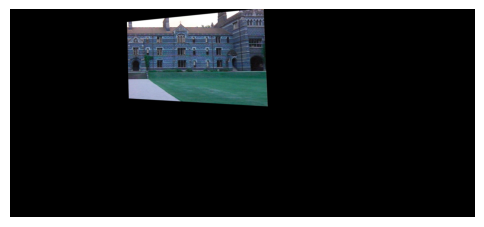

In [278]:
result = rightshift(right_list, leftImage)

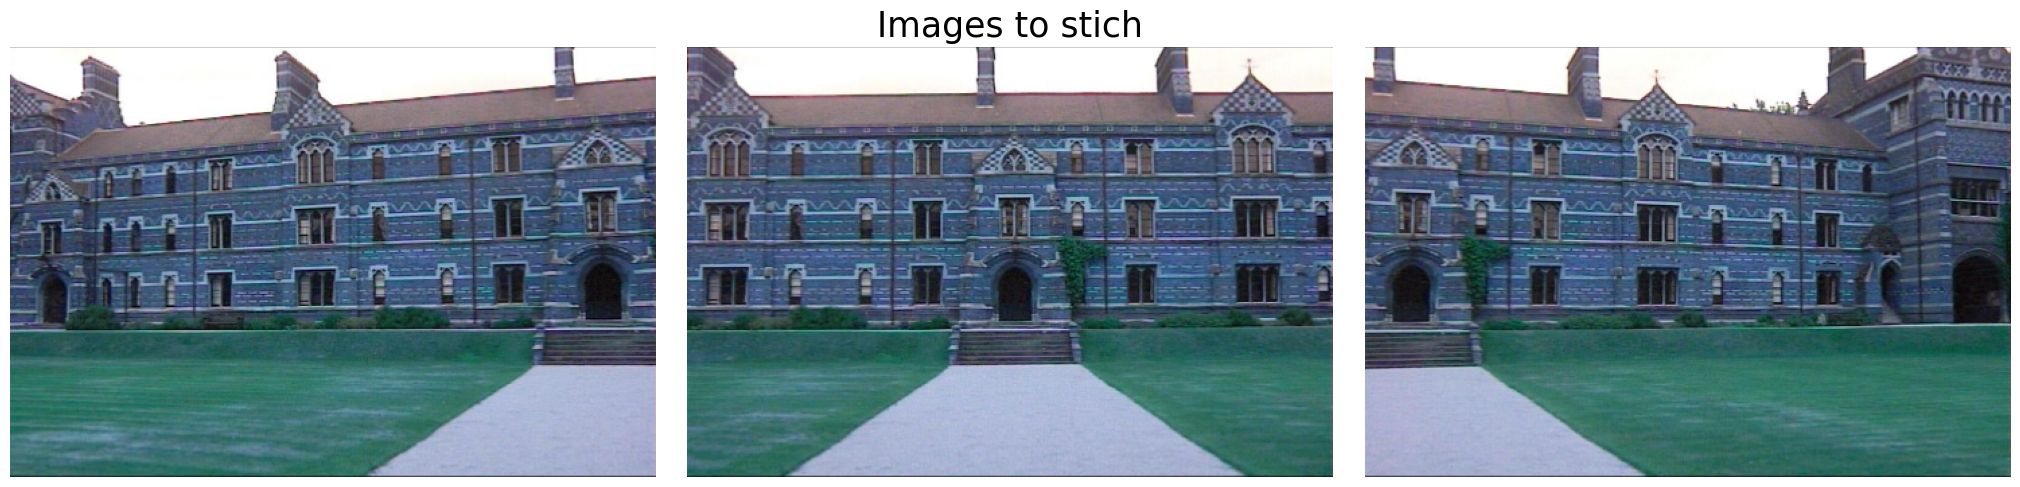

True

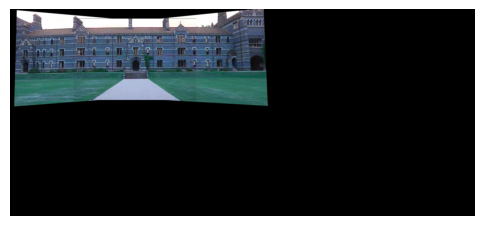

In [279]:
fig = plt.figure(figsize=(20, 5))
for i in range(len(list_images)):
    plt.subplot(1,len(list_images),i+1)
    plt.imshow(list_images[i])
    plt.axis('off')
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.95, hspace=0.05, wspace=0.05) 
plt.suptitle('Images to stich', size=25)
plt.show()
imshow(cv2.resize(result, (1800, 800)))
cv2.imwrite("../data_output/keble_stitching_paronama.jpg", result)